In [1]:
import numpy as np
from numpy.random import multivariate_normal as mvnrnd
from scipy.stats import wishart
from scipy.stats import invwishart
from numpy.linalg import inv as inv
import time
import scipy.io

def kr_prod(a, b):
    return np.einsum('ir, jr -> ijr', a, b).reshape(a.shape[0] * b.shape[0], -1)

def cov_mat(mat):
    dim1, dim2 = mat.shape
    new_mat = np.zeros((dim2, dim2))
    mat_bar = np.mean(mat, axis = 0)
    for i in range(dim1):
        new_mat += np.einsum('i, j -> ij', mat[i, :] - mat_bar, mat[i, :] - mat_bar)
    return new_mat

def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)

def mnrnd(M, U, V):
    """
    Generate matrix normal distributed random matrix.
    M is a m-by-n matrix, U is a m-by-m matrix, and V is a n-by-n matrix.
    """
    dim1, dim2 = M.shape
    X0 = np.random.rand(dim1, dim2)
    P = np.linalg.cholesky(U)
    Q = np.linalg.cholesky(V)
    return M + np.matmul(np.matmul(P, X0), Q.T)

def BTMF(dense_mat, sparse_mat, init, rank, time_lags, maxiter1, maxiter2):
    """Bayesian Temporal Matrix Factorization, BTMF."""
    W = init["W"]
    X = init["X"]
    
    d = time_lags.shape[0]
    dim1, dim2 = sparse_mat.shape
    pos = np.where((dense_mat != 0) & (sparse_mat == 0))
    position = np.where(sparse_mat != 0)
    binary_mat = np.zeros((dim1, dim2))
    binary_mat[position] = 1
    
    beta0 = 1
    nu0 = rank
    mu0 = np.zeros((rank))
    W0 = np.eye(rank)
    tau = 1
    alpha = 1e-6
    beta = 1e-6
    S0 = np.eye(rank)
    Psi0 = np.eye(rank * d)
    M0 = np.zeros((rank * d, rank))
    
    W_plus = np.zeros((dim1, rank))
    X_plus = np.zeros((dim2, rank))
    X_new_plus = np.zeros((dim2 + 1, rank))
    A_plus = np.zeros((rank, rank, d))
    mat_hat_plus = np.zeros((dim1, dim2 + 1))
    stt = time.time()
    for iters in range(maxiter1):
        W_bar = np.mean(W, axis = 0)
        var_mu_hyper = (dim1 * W_bar)/(dim1 + beta0)
        var_W_hyper = inv(inv(W0) + cov_mat(W) + dim1 * beta0/(dim1 + beta0) * np.outer(W_bar, W_bar))
        var_Lambda_hyper = wishart(df = dim1 + nu0, scale = var_W_hyper, seed = None).rvs()
        var_mu_hyper = mvnrnd(var_mu_hyper, inv((dim1 + beta0) * var_Lambda_hyper))
        
        var1 = X.T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, binary_mat.T).reshape([rank, rank, dim1]) + np.dstack([var_Lambda_hyper] * dim1)
        var4 = (tau * np.matmul(var1, sparse_mat.T)
                + np.dstack([np.matmul(var_Lambda_hyper, var_mu_hyper)] * dim1)[0, :, :])
        for i in range(dim1):
            inv_var_Lambda = inv(var3[:, :, i])
            W[i, :] = mvnrnd(np.matmul(inv_var_Lambda, var4[:, i]), inv_var_Lambda)
        if iters + 1 > maxiter1 - maxiter2:
            W_plus += W
        
        Z_mat0 = X[0 : np.max(time_lags), :]
        Z_mat = X[np.max(time_lags) : dim2, :]
        Q_mat = np.zeros((dim2 - np.max(time_lags), rank * d))
        for t in range(np.max(time_lags), dim2):
            Q_mat[t - np.max(time_lags), :] = X[t - time_lags, :].reshape([rank * d])
        var_Psi = inv(inv(Psi0) + np.matmul(Q_mat.T, Q_mat))
        var_M = np.matmul(var_Psi, np.matmul(inv(Psi0), M0) + np.matmul(Q_mat.T, Z_mat))
        var_S = (S0 + np.matmul(Z_mat.T, Z_mat) + np.matmul(np.matmul(M0.T, inv(Psi0)), M0) 
                 - np.matmul(np.matmul(var_M.T, inv(var_Psi)), var_M))
        Sigma = invwishart(df = nu0 + dim2 - np.max(time_lags), scale = var_S, seed = None).rvs()
        Lambda_x = inv(Sigma)
        A = mat2ten(mnrnd(var_M, var_Psi, Sigma).T, np.array([rank, rank, d]), 0)
        if iters + 1 > maxiter1 - maxiter2:
            A_plus += A

        var1 = W.T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, binary_mat).reshape([rank, rank, dim2]) + np.dstack([Lambda_x] * dim2)
        var4 = tau * np.matmul(var1, sparse_mat)
        for t in range(dim2):
            Mt = np.zeros((rank, rank))
            Nt = np.zeros(rank)
            if t < np.max(time_lags):
                Qt = np.zeros(rank)
            else:
                Qt = np.matmul(Lambda_x, np.matmul(ten2mat(A, 0), X[t - time_lags, :].reshape([rank * d])))
            if t < dim2 - np.min(time_lags):
                if t >= np.max(time_lags) and t < dim2 - np.max(time_lags):
                    index = list(range(0, d))
                else:
                    index = list(np.where((t + time_lags >= np.max(time_lags)) & (t + time_lags < dim2)))[0]
                for k in index:
                    Ak = A[:, :, k]
                    Mt += np.matmul(np.matmul(Ak.T, Lambda_x), Ak)
                    A0 = A.copy()
                    A0[:, :, k] = 0
                    var5 = (X[t + time_lags[k], :] 
                            - np.matmul(ten2mat(A0, 0), X[t + time_lags[k] - time_lags, :].reshape([rank * d])))
                    Nt += np.matmul(np.matmul(Ak.T, Lambda_x), var5)
            var_mu = var4[:, t] + Nt + Qt
            if t < np.max(time_lags):
                inv_var_Lambda = inv(var3[:, :, t] + Mt - Lambda_x + np.eye(rank))
            else:
                inv_var_Lambda = inv(var3[:, :, t] + Mt)
            X[t, :] = mvnrnd(np.matmul(inv_var_Lambda, var_mu), inv_var_Lambda)
        mat_hat = np.matmul(W, X.T)
        
        X_new = np.zeros((dim2 + 1, rank))
        if iters + 1 > maxiter1 - maxiter2:
            X_new[0 : dim2, :] = X.copy()
            vec = np.matmul(ten2mat(A, 0), X_new[t - time_lags, :].reshape([rank * d]))
            vec[vec < 0] = 0
            X_new[dim2, :] = vec.copy()
            X_new_plus += X_new
            mat_hat_plus += np.matmul(W, X_new.T)
        
        tau = np.random.gamma(alpha + 0.5 * sparse_mat[position].shape[0], 
                              1/(beta + 0.5 * np.sum((sparse_mat - mat_hat)[position] ** 2)))
        if (iters + 1) % 10 == 0:
            print('Iter: %d, time cost: %d'%(iters + 1, time.time() - stt))
            stt = time.time()

    W = W_plus/maxiter2
    X_new = X_new_plus/maxiter2
    A = A_plus/maxiter2
    mat_hat = mat_hat_plus/maxiter2
    if maxiter1 >= 100:
        final_mape = np.sum(np.abs(dense_mat[pos] - mat_hat[pos])/dense_mat[pos])/dense_mat[pos].shape[0]
        final_rmse = np.sqrt(np.sum((dense_mat[pos] - mat_hat[pos]) ** 2)/dense_mat[pos].shape[0])
        print('Imputation MAPE: {:.6}'.format(final_mape))
        print('Imputation RMSE: {:.6}'.format(final_rmse))
        print()
    
    return mat_hat, W, X_new, A



def OnlineBTMF(sparse_vec, init, time_lags, maxiter1, maxiter2):
    """Online Bayesain Temporal Matrix Factorization"""
    W = init["W"]
    X = init["X"]
    A = init["A"]

    d = time_lags.shape[0]
    dim = sparse_vec.shape[0]
    t, rank = X.shape
    position = np.where(sparse_vec != 0)
    binary_vec = np.zeros(dim)
    binary_vec[position] = 1

    tau = 1
    alpha = 1e-6
    beta = 1e-6
    nu0 = rank
    W0 = np.eye(rank)
    var_mu0 = np.matmul(ten2mat(A, 0), X[t - 1 - time_lags, :].reshape([rank * d]))

    X_new_plus = np.zeros((t + 1, rank))
    mat_hat_plus = np.zeros((W.shape[0], t + 1))
    for iters in range(maxiter1):
        vec0 = X[t - 1, :] - var_mu0
        Lambda_x = wishart(df = nu0 + 1, scale = inv(inv(W0) + np.outer(vec0, vec0)), seed = None).rvs()
        
        var1 = W.T
        var2 = kr_prod(var1, var1)
        var_mu = tau * np.matmul(var1, sparse_vec) + np.matmul(Lambda_x, var_mu0)
        inv_var_Lambda = inv(tau * np.matmul(var2, binary_vec).reshape([rank, rank]) + Lambda_x)
        X[t - 1, :] = mvnrnd(np.matmul(inv_var_Lambda, var_mu), inv_var_Lambda)
        
        tau = np.random.gamma(alpha + 0.5 * sparse_vec[position].shape[0], 
                              1/(beta + 0.5 * np.sum((sparse_vec - np.matmul(W, X[t - 1, :]))[position] ** 2)))
        
        X_new = np.zeros((t + 1, rank))
        if iters + 1 > maxiter1 - maxiter2:
            X_new[0 : t, :] = X.copy()
            X_new[t, :] = np.matmul(ten2mat(A, 0), X_new[t - time_lags, :].reshape([rank * d]))
            X_new_plus += X_new
            mat_hat_plus += np.matmul(W, X_new.T)
        

    X_new = X_new_plus/maxiter2
    mat_hat = mat_hat_plus/maxiter2
    return mat_hat, X_new


def st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter):
    T = dense_mat.shape[1]
    start_time = T - pred_time_steps
    dense_mat0 = dense_mat[:, 0 : start_time]
    sparse_mat0 = sparse_mat[:, 0 : start_time]
    dim1, dim2 = sparse_mat0.shape
    d = time_lags.shape[0]
    mat_hat = np.zeros((dim1, pred_time_steps))
    mat_rec = np.zeros((dim1, pred_time_steps))
    sttt = time.time()
    for t in range(pred_time_steps + 1):
        if t == 0:
            init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank)}
            mat, W, X, A = BTMF(dense_mat0, sparse_mat0, init, rank, time_lags, maxiter[0], maxiter[1])
        else:
            sparse_vec = sparse_mat[:, start_time + t - 1]
            if np.where(sparse_vec != 0)[0].shape[0] > 0:
                init = {"W": W, "X": X[- np.max(time_lags) :, :], "A": A}
                mat, X = OnlineBTMF(sparse_vec, init, time_lags, maxiter[2], maxiter[3])
            else:
                X0 = np.zeros((np.max(time_lags) + 1, rank))
                X0[: -1, :] = X[- np.max(time_lags) :, :]
                X0[-1, :] = np.matmul(ten2mat(A, 0), X[-1 - time_lags, :].reshape([rank * d]))
                X = X0.copy()
                mat = np.matmul(W, X.T)
            mat_rec[:, t - 1] = mat[:, -2]
        if t != pred_time_steps:
            mat_hat[:, t] = mat[:, -1]
        if (t + 1) % 200 == 0:
            print('Time step: %d, Time cost: %ds'%(t + 1, time.time() - sttt))
            sttt = time.time()

    small_dense_mat = dense_mat[:, start_time : dense_mat.shape[1]]
    pos = np.where(small_dense_mat != 0)
    final_mape = np.mean(np.abs((small_dense_mat[pos] - mat_hat[pos]) / small_dense_mat[pos])) * 100
    final_rmse = np.sqrt(np.mean(np.square(small_dense_mat[pos] - mat_hat[pos])))
    print('Prediction error:')
    print('Final RMSE: {:.6}'.format(final_rmse))
    print('Final MAPE: {:.6}'.format(final_mape))
    print()

    small_sparse_mat = sparse_mat[:, start_time : dense_mat.shape[1]]
    pos = np.where((small_dense_mat != 0) & (small_sparse_mat == 0))
    final_mape = np.mean(np.abs((small_dense_mat[pos] - mat_rec[pos]) / small_dense_mat[pos])) * 100
    final_rmse = np.sqrt(np.mean(np.square(small_dense_mat[pos] - mat_rec[pos])))
    print('Imputation error:')
    print('Final RMSE: {:.6}'.format(final_rmse))
    print('Final MAPE: {:.6}'.format(final_mape))
    print()
    return mat_rec, mat_hat

In [2]:
start_time = time.time()
missing_rate = 0.4
print('Missing rate = %f'%missing_rate)

tensor = scipy.io.loadmat('../datasets/Shanghai-pollutant-dataset/NTS_tensor.mat')
dense_tensor = tensor['tensor']

print('The shape of the initial dataset is:')
print(dense_tensor.shape)
dim1, dim2, dim3 = dense_tensor.shape

# =============================================================================
### Random missing (PM) scenario
### Set the PM scenario by:
tensor = scipy.io.loadmat('../datasets/Shanghai-pollutant-dataset/NTS_random_tensor.mat')
random_tensor = tensor['tensor']
binary_tensor = np.ones((dim1, dim2, dim3))
binary_tensor[random_tensor < missing_rate] = 0

### Non random missing (CM) scenario
# ### Set the CM scenario by:
'''
missing_period = 6 #data missing in continuous [6, 12, 24, 48] hours
random_array_file = '../datasets/Shanghai-pollutant-dataset/NTS_random_array' + str(missing_period) + '.mat'
tensor = scipy.io.loadmat(random_array_file)
random_array = tensor['array'][0]
binary_reshape_tensor = np.ones_like(dense_tensor)
binary_reshape_tensor = binary_reshape_tensor.reshape(dim1,dim2,int(dim3 / missing_period),missing_period)
pos = np.where(random_array < missing_rate)
binary_reshape_tensor[:, :, pos, :] = 0
binary_tensor = binary_reshape_tensor.reshape(dim1, dim2, dim3)
'''
# =============================================================================
sparse_tensor = np.multiply(dense_tensor, binary_tensor)

dense_tensor = dense_tensor[:, :, 5768:]
sparse_tensor = sparse_tensor[:, :, 5768:]

print(sparse_tensor.shape) 

dim1, dim2, dim3 = dense_tensor.shape
dense_mat = dense_tensor.reshape(dim1 * dim2, dim3)
sparse_mat = sparse_tensor.reshape(dim1 * dim2, dim3)
print(sparse_mat.shape)

start = time.time()
pred_time_steps = 820
rank = 60
time_lags = np.array(1, 2, 24)
maxiter = np.array([200, 100, 100, 50])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_rec, mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))
print('=================')

Missing rate = 0.400000
The shape of the initial dataset is:
(12, 6, 15768)
(12, 6, 10000)
(72, 10000)
Iter: 10, time cost: 188
Iter: 20, time cost: 188
Iter: 30, time cost: 187
Iter: 40, time cost: 187
Iter: 50, time cost: 186
Iter: 60, time cost: 206
Iter: 70, time cost: 216
Iter: 80, time cost: 216
Iter: 90, time cost: 216
Iter: 100, time cost: 187
Iter: 110, time cost: 184
Iter: 120, time cost: 184
Iter: 130, time cost: 197
Iter: 140, time cost: 204
Iter: 150, time cost: 197
Iter: 160, time cost: 196
Iter: 170, time cost: 196
Iter: 180, time cost: 196
Iter: 190, time cost: 196
Iter: 200, time cost: 195
Imputation MAPE: 0.174736
Imputation RMSE: 6.41381



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:196: RuntimeWarning: covariance is not symmetric positive-semidefinite.


Time step: 200, Time cost: 4019s
Time step: 400, Time cost: 87s
Time step: 600, Time cost: 87s
Time step: 800, Time cost: 87s
Prediction error:
Final RMSE: 14.988
Final MAPE: 36.2127

Imputation error:
Final RMSE: 14.9674
Final MAPE: 39.6337

Running time: 4291 seconds


In [8]:
np.save('Shanghai_0.4_PM_pred_btmf.npy', mat_hat)
np.save('Shanghai_0.4_PM_rec_btmf.npy', mat_rec)

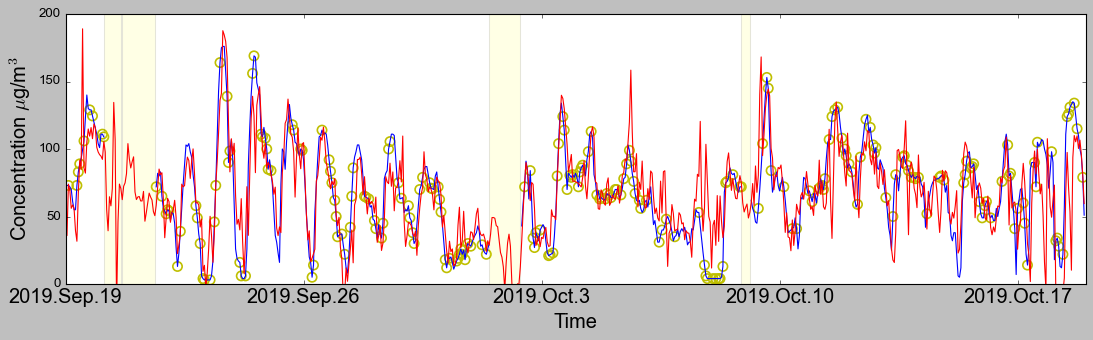

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

test_set = sparse_mat[:, -820:]
test_ground_truth = dense_mat[:, -820:]

fig = plt.figure(figsize = (15, 4.5))
plt.style.use('classic')
plt.rcParams['font.family'] = 'Arial'
ax = fig.add_axes([0.18, 0.20, 0.85, 0.75])
# ax = fig.add_axes([0, 0, 1, 1])
ax.set_facecolor('white')
# ax.set_facecolor((1.0, 0.47, 0.42))
pollutant = 5 #66#163#35#67
start_time = 100 #3312
end_time = 820 #3528
array = test_ground_truth[pollutant, start_time:end_time]
nonzero = [[]]
pos = np.where(array != 0)
seg = 0
for i in range(len(pos[0])):
    if (i == len(pos[0]) - 1) or (pos[0][i + 1] == pos[0][i] + 1): # continuous
        nonzero[seg].append(pos[0][i])
    if (i != len(pos[0]) - 1) and (pos[0][i + 1] != pos[0][i] + 1): # dis continuous
        nonzero[seg].append(pos[0][i])
        nonzero.append([])
        seg += 1

Scatter_point = []
continuous_seg = []
for i in range(len(nonzero)):
    if len(nonzero[i]) == 1:
        Scatter_point.append(nonzero[i][0])
    else:
        continuous_seg.append(nonzero[i])

for i in range(len(continuous_seg)):
    plt.plot(continuous_seg[i], array[continuous_seg[i]], label = 'concentration', marker='', markerfacecolor='b', markersize=8, color='blue', linewidth=1)
# plt.plot(array[pos], label = 'concentration', marker='', markerfacecolor='blue', markersize=8, color='red', linewidth=2)

# plt.scatter(Scatter_point, array[Scatter_point], facecolors='none', edgecolors='b', s=3)
# plt.plot(test_ground_truth[pollutant, start_time:end_time], label = 'Ground Truth', marker='', markerfacecolor='blue', markersize=8, color='blue', linewidth=1)
array_ground_truth = test_ground_truth[pollutant, start_time:end_time]
pos = np.where(array_ground_truth == 0)
zero = [[]]
seg = 0
for i in range(len(pos[0])):
    if (i == len(pos[0]) - 1) or (pos[0][i + 1] == pos[0][i] + 1):
        zero[seg].append(pos[0][i])
    if (i != len(pos[0]) - 1) and (pos[0][i + 1] != pos[0][i] + 1):
        zero[seg].append(pos[0][i])
        zero.append([])
        seg += 1

RM = []
NM = []
for i in range(len(zero)):
    if len(zero[i]) == 1:
        RM.append(zero[i][0])
    else:
        NM.append(zero[i])


# plt.yticks(np.arange(0, 150, 40), [0, 40, 80, 120])
# plt.xticks(np.arange(0, 230, 10))#, [0, 50, 100, 150, 200, 250])
plt.ylim(0, 200)
plt.xlim(0, 720)
ax.set_ylabel("Concentration $\mu$g/m$^3$", fontsize=18)
ax.set_xlabel("Time", fontsize=18)
# ax.set_title("Speed prediction for sensor No.%d"%(pollutant))
# ax.grid(color = 'gray', linestyle = '-', linewidth = 0.4, alpha = 0.5, axis = 'x')
# plt.scatter(RM, array[np.array(RM)], facecolors='none', edgecolors='y', s=30)
array_sparse = test_set[pollutant, start_time:end_time]
pos = np.where((array_sparse == 0) & (array_ground_truth != 0))


plt.scatter(pos, array_ground_truth[pos], facecolors='none', edgecolors='y', s=70, linewidth=1.5)
plt.plot(mat_hat[pollutant, start_time : end_time], label = 'Predicted', marker='', markerfacecolor='blue', markersize=8, color='red', linewidth=1)

for i in range(len(NM)):
    ax.add_patch(patches.Rectangle((NM[i][0] - 1, 0), NM[i][-1] - NM[i][0] + 1, 200, alpha = 0.1, facecolor = 'yellow'))
plt.xticks(np.arange(0, 720, 168), ["2019.Sep.19",  "2019.Sep.26", 
                                        "2019.Oct.3", "2019.Oct.10", 
                                   "2019.Oct.17"], fontsize=18)
# plt.legend(loc = 'best')
file_n = 'prediction_shanghai_btmf_pm0.4' + '.png'
plt.savefig(file_n, bbox_inches = 'tight')
plt.show()